Updated XGBoost model including: TargetEncoder for newly added column "locality_name", pipeline and hyperparameter tuning, feature importance plot. To do still: log transform and cross validation

In [5]:
# ---------------------------
# 0) Imports
# ---------------------------
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_is_fitted
from xgboost import XGBRegressor

# ---------------------------
# 1) Load dataset
# ---------------------------
df = pd.read_csv("../data/raw/filtered_final_cleaned_data.csv")

# ---------------------------
# 2) Configuration
# ---------------------------
TARGET = "price (€)"
LOCALITY_COL = "locality_name"
CATEGORICAL_OHE = ["state_of_building", "subtype", "type", "province"]
DROP_COLUMNS   = ["property_ID", "postal_code"]
RANDOM_STATE   = 42

# ---------------------------
# 3) Prepare X/y
# ---------------------------
def prepare_X_y(df):
    df = df.dropna(subset=[TARGET]).reset_index(drop=True)
    cols_to_drop = [c for c in DROP_COLUMNS if c in df.columns]
    X = df.drop(columns=cols_to_drop + [TARGET], errors="ignore")
    y = df[TARGET].copy()
    return X, y

X, y = prepare_X_y(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ---------------------------
# 4) Impute numeric columns
# ---------------------------
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != LOCALITY_COL]

num_imputer = SimpleImputer(strategy="mean")
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols]  = num_imputer.transform(X_test[num_cols])

# ---------------------------
# 5) Impute categorical columns
# ---------------------------
for col in CATEGORICAL_OHE:
    if col in X_train.columns:
        X_train[col] = X_train[col].fillna("unknown")
        X_test[col]  = X_test[col].fillna("unknown")

if LOCALITY_COL in X_train.columns:
    X_train[LOCALITY_COL] = X_train[LOCALITY_COL].fillna("unknown")
    X_test[LOCALITY_COL]  = X_test[LOCALITY_COL].fillna("unknown")

# ---------------------------
# 6) REPLACED: Robust TargetEncoderCV
# ---------------------------
class TargetEncoderCV:
    def __init__(self, col=None, n_splits=5, smoothing=10,
                 min_samples_leaf=1, random_state=0):
        self.col = col
        self.n_splits = int(n_splits)
        self.smoothing = float(smoothing)
        self.min_samples_leaf = int(min_samples_leaf)
        self.random_state = random_state
        self.mapping_ = {}
        self.global_mean_ = None
        self.fitted_ = False

    def _smooth_mean(self, count, mean, global_mean):
        weight = 1.0 / (1.0 + np.exp(-(count - self.min_samples_leaf) / self.smoothing))
        return weight * mean + (1.0 - weight) * global_mean

    def _ensure_series(self, arr):
        if isinstance(arr, pd.Series):
            return arr.astype(object).reset_index(drop=True)
        return pd.Series(arr).astype(object).reset_index(drop=True)

    def fit(self, X_col, y):
        Xs = self._ensure_series(X_col)
        ys = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = ys.mean()

        df_tmp = pd.DataFrame({"key": Xs, "y": ys})
        grouped = df_tmp.groupby("key")["y"].agg(["count", "mean"])
        grouped["encoded"] = grouped.apply(
            lambda r: self._smooth_mean(r["count"], r["mean"], self.global_mean_), axis=1
        )
        self.mapping_ = grouped["encoded"].to_dict()
        self.fitted_ = True
        return self

    def fit_transform(self, X_col, y):
        Xs = self._ensure_series(X_col)
        ys = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = ys.mean()

        oof = pd.Series(index=Xs.index, dtype=float)
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        for train_idx, val_idx in kf.split(Xs):
            df_fold = pd.DataFrame({
                "key": Xs.iloc[train_idx].reset_index(drop=True),
                "y":   ys.iloc[train_idx].reset_index(drop=True)
            })
            grouped = df_fold.groupby("key")["y"].agg(["count", "mean"])
            grouped["encoded"] = grouped.apply(
                lambda r: self._smooth_mean(r["count"], r["mean"], self.global_mean_),
                axis=1
            )
            fold_map = grouped["encoded"].to_dict()

            oof.iloc[val_idx] = Xs.iloc[val_idx].map(fold_map).fillna(self.global_mean_).values

        # Full mapping for test transform
        df_full = pd.DataFrame({"key": Xs, "y": ys})
        grouped_full = df_full.groupby("key")["y"].agg(["count", "mean"])
        grouped_full["encoded"] = grouped_full.apply(
            lambda r: self._smooth_mean(r["count"], r["mean"], self.global_mean_),
            axis=1
        )
        self.mapping_ = grouped_full["encoded"].to_dict()
        self.fitted_ = True

        return oof.values

    def transform(self, X_col):
        check_is_fitted(self, "fitted_")
        Xs = self._ensure_series(X_col)
        return Xs.map(self.mapping_).fillna(self.global_mean_).values

# ---------------------------
# 7) Apply Target Encoder
# ---------------------------
if LOCALITY_COL in X_train.columns:
    te = TargetEncoderCV(col=LOCALITY_COL, n_splits=5,
                         smoothing=10, min_samples_leaf=5,
                         random_state=RANDOM_STATE)

    X_train["locality_te"] = te.fit_transform(X_train[LOCALITY_COL], y_train)
    X_test["locality_te"]  = te.transform(X_test[LOCALITY_COL])

else:
    mean_val = y_train.mean()
    X_train["locality_te"] = mean_val
    X_test["locality_te"]  = mean_val

# ---------------------------
# 8) Build ColumnTransformer
# ---------------------------
NUMERIC_COLS = [c for c in num_cols if c in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
         [c for c in CATEGORICAL_OHE if c in X_train.columns]),
    ],
    remainder="passthrough"
)

# 9) XGBoost Model
# ------------------------------------------------------------
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=8,
    subsample=1,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"  # fast + compatible on Mac OS
)

pipeline = Pipeline([
    ("preproc", preprocessor),
    ("model", xgb_model)
])

# ---------------------------
# 10) Final feature list
# ---------------------------
feature_cols = (
    [c for c in CATEGORICAL_OHE if c in X_train.columns] +
    NUMERIC_COLS +
    ["locality_te"]
)

X_train_final = X_train[feature_cols].copy()
X_test_final  = X_test[feature_cols].copy()

print("Final feature count:", X_train_final.shape[1])

# ---------------------------
# 11) Fit and evaluate
# ---------------------------
pipeline.fit(X_train_final, y_train)

y_pred_train = pipeline.predict(X_train_final)
y_pred_test  = pipeline.predict(X_test_final)

metrics = {
    "train": {
        "MAE": mean_absolute_error(y_train, y_pred_train),
        "RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "R2": r2_score(y_train, y_pred_train)
    },
    "test": {
        "MAE": mean_absolute_error(y_test, y_pred_test),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "R2": r2_score(y_test, y_pred_test)
    }
}

print(metrics)


Final feature count: 15
{'train': {'MAE': 48758.66015625, 'RMSE': np.float64(90862.11091538651), 'R2': 0.8884062767028809}, 'test': {'MAE': 69770.1875, 'RMSE': np.float64(131043.6649060152), 'R2': 0.7132874131202698}}


In [ ]:
# Hyperparameter tuning and feature importance plotting

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# define pipeline

pipeline = Pipeline([
    ("preproc", preprocessor),
    ("model", XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"  # fast + compatible on Mac OS
    ))
])

# hyperparameter tuning
param_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 1],
    "model__colsample_bytree": [0.7, 0.8, 1]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

search.fit(X_train_final, y_train)

print("Best params:", search.best_params_)
print("Best R2:", search.best_score_)

# evaluate tuned model
best_model = search.best_estimator_

y_pred_train = best_model.predict(X_train_final)
y_pred_test  = best_model.predict(X_test_final)

metrics = {
    "train": {
        "MAE": mean_absolute_error(y_train, y_pred_train),
        "RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "R2": r2_score(y_train, y_pred_train)
    },
    "test": {
        "MAE": mean_absolute_error(y_test, y_pred_test),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "R2": r2_score(y_test, y_pred_test)
    }
}


print(metrics)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'model__subsample': 1, 'model__n_estimators': 300, 'model__max_depth': 4, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Best R2: 0.6345446705818176
{'train': {'MAE': 68046.15625, 'RMSE': np.float64(130215.89555810764), 'R2': 0.7708065509796143}, 'test': {'MAE': 74578.5, 'RMSE': np.float64(132361.0364419983), 'R2': 0.7074938416481018}}


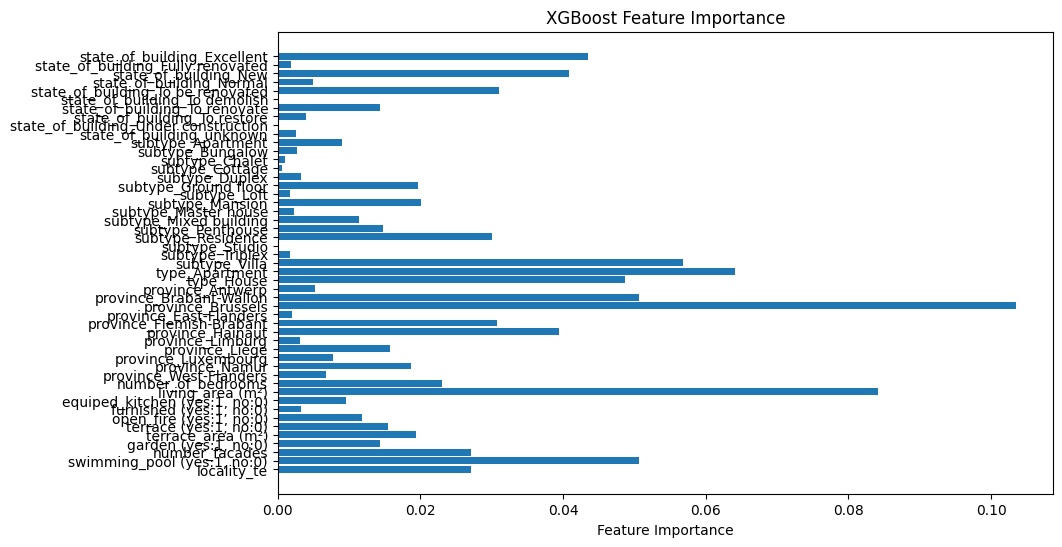

In [6]:
# Feature importance plot

# Extract feature names from pipeline
feature_names = (
    list(preprocessor.transformers_[0][1].get_feature_names_out(CATEGORICAL_OHE)) + 
    NUMERIC_COLS + 
    ["locality_te"]
)

# Get feature importances from XGB model
importances = best_model.named_steps['model'].feature_importances_

# Plot
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()
